# Chapter 3: Linear Neural Networks for Regression

### Dhuvi Karthikeyan

##### 1/11/2023

Minimal notes just on the things I had forgotten/wish to review for retention.

## 3.1 Linear Regression

### 3.1.1 Basics

#### The Model 
$$ \hat{y} = \mathbf{w}^T\mathbf{x} + b $$
$$ \hat{\mathbf{y}} = \mathbf{X}\mathbf{w} + b $$

Design matrix is the matrix X s.t. rows are examples and columns are features. All the data


Affine transformation that decomposes into a linear transformation by weighted sum fo input features and then translation by the addition of a bias term. 

Conditional mean: $E[Y|X=x]$ -> MLE Estimates

#### Loss Function

$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2}(\hat{y^{(i)}}-y^{(i)})^2$$
$$ L(\mathbf{w}, b) = \frac{1}{n}\sum_{i \in Data}l^{(i)}(\mathbf{w}, b)$$

**Analytic Solution to Linear Regression:** 

$$ 0 = \partial ||y-Xw||^2 = -2X^T(y-Xw)$$
$$ 0 = -2X^Ty+2X^TXw$$
$$ X^Ty = X^TXw$$
$$ (X^TX)^{-1}X^Ty = w^*$$

### 3.1.3 Normal Distribution and the Squared Loss

Take the following: For a given x, we observe y with a value decomposed as the following:
$$ y = \textbf{w}^Tx + b + \epsilon ~ N(0, \sigma^2)$$

$$ P(y | x) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp{(-\frac{1}{2\sigma^2}(y - \textbf{w}^Tx -b)^2)}$$ 

$$ P(y | X) = \prod_{i=1}^np(y^{(i)}|x^{(i)}) $$

$$ -logP(y|X) = \sum_{i=1}^n \frac{1}{2}log(2\pi\sigma^2) + \frac{1}{2\sigma^2}(y^{(i)} - \textbf{w}^Tx^{(i)} - b)$$

Since the solution does not depend on $\sigma$ we can ignore the terms involving $\sigma$:

$$ -logP(y|X) = \sum_{i=1}^n  (y^{(i)} - \textbf{w}^Tx^{(i)} - b)$$

This is the same loss function that is being minimized using the L2 loss.

## 3.2 Object-Oriented Design for Implementation

### 3.2.1 Utilities

In [1]:
# Useful function for adding attributes to objects after instantiation

def add_to_class(Class):
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

In [2]:
class C:
    def __init__(self):
        self.instantiated = True
        
c = C()

In [3]:
@add_to_class(C)                  # Limits the scope of adding attributes to just the class
def add_name(self, name):
    self.name = name
    
def add_directive(obj, directive): # Global scope to all objects [Not best practices]
    obj.directive = directive
    
@add_to_class(C)
def add_subdirective(self, subdirective):
    self.subdirective = subdirective

In [4]:
c.add_name('ClassC')

In [5]:
c.name

'ClassC'

In [6]:
add_directive(c, "Exist")

In [7]:
c.directive

'Exist'

In [11]:
c.add_subdirective("Pass the butter.")
c.subdirective

'Pass the butter.'

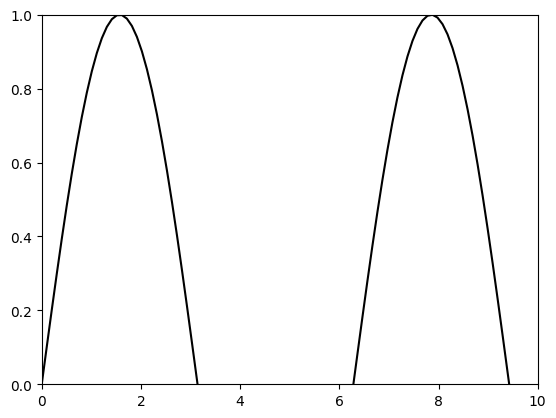

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import time

x = np.linspace(0, 10, 100)
y = np.sin(x)

fig, ax = plt.subplots()
line, = ax.plot(x, y, color='k')

for n in range(len(x)):
    time.sleep(1)
    line.set_data(x[:n], y[:n])
    ax.axis([0, 10, 0, 1])
    fig.canvas.draw()

## 3.4 Linear Regression from Scratch

This is the main problem from HW1 and is pulled from my implementation in HW1

In [22]:
# Define the DataLoader Class

class DataLoader:
    """
    Implements a Data Loading Class for passing mini-batches to model after
    minor processing to ensure that matrix multiplication works. Assumes shuffle
    to be true.
    """
    def __init__(
          self, 
          inputs,
          labels,
          batch_size
    ):
        self.__len__ = len(labels)
        self.data = self.gen_tensor(inputs)
        self.labels = labels
        self.batch_size = batch_size
        self.called_idx = np.array([], dtype=int)
        self.prefetch = self.__get_idx__()

  
    def reshape_input(self, inputs):
        '''Reshapes input of dims >= 1 to a matrix of n x n_features'''
        n_examples = inputs.shape[0] #Assumes first dim is n_examples
        assert n_examples == self.__len__
        return inputs.reshape(n_examples, int(inputs.size/n_examples))

        def gen_tensor(self, inputs):
            '''Checks for iterable inputs and runs reshape above''' 
            try:
                iter(inputs)
            except TypeError:
                print("Inputs is not an iterable.")
            return self.reshape_input(inputs)

    def __get_idx__(self):
        '''Check that we have enough examples for another batch_size'''
        if self.__len__ - len(self.called_idx) < self.batch_size:
          # On epoch end reset the called indices
          self.called_idx = np.array([], dtype=int)
        remaining_idx = np.delete(np.arange(self.__len__), list(self.called_idx))
        idx = np.random.choice(remaining_idx, self.batch_size, replace=False)
        self.called_idx = np.append(self.called_idx, idx)
        return idx

    def _get_item_(self):
        '''Get a batch of the data when called with batch_size'''
        sampled_idx = self.__get_idx__()
        return (self.data[sampled_idx, :], self.labels[sampled_idx])

In [23]:
# Define the LinearRegression Model Class

class LinearRegression:
    """
    Implements a Linear Regression Model Class for performing linear regression
    without the closed form solution. Randomly initializes weights and biases 
    before using mini-batch SGD to optimize weights
    """
    def __init__(
      self,
      input_dim
    ):
        self.weights = np.random.randn(input_dim)
        self.bias = 0
    
    def forward(self, X):
        #Vectorized implementation of Forward Call w// broadcasting for bias
        return X @ self.weights + self.bias

In [1]:
# Define the Gradient Descent Class

class SGD:
    """
    Implements gradient descent algorithm. Works with arbitrary models
    and loss functions (whose gradients are manually implemented).
    """
    def __init__(
        self,
        model, 
        learning_rate,
        grad_fxn
    ):
        self.eta = learning_rate
        self.grad = grad_fxn
        self.model = model

    def step(self, inputs, preds, labels):
        grads = self.grad(inputs, preds, labels)
        self.update_params(grads)

    def update_params(self, grads):
        params = self.model.params.keys()
        for i,p in enumerate(params):
            self.model.params[p] -= self.eta*grads[i]

In [ ]:
# Define the Train_Iters Function
def train_iters(iterations, data_loader, model, lossfn, optimizer):
    running_loss = 0
    loss = []
    for i in tqdm(range(iterations)):
        x,y = data_loader._get_item_()
        preds = model.forward(x)
        running_loss += lossfn(preds, y)
        if  (i + 1) % 1000 == 0:
            loss += [running_loss/1000]
            running_loss = 0
        optimizer.step(x, preds, y)
    return loss

In [ ]:
# Define the L2 Loss Function and Gradients

def l2_loss(preds, targets):
    return 1/2*np.sum(np.square(preds-targets))

def l2_grad(inputs, preds, targets):
    weights_grad = np.dot(inputs.T, preds-targets)/len(preds)
    bias_grad = np.dot(np.ones(len(targets)).T, preds-targets)/len(preds) 
    return weights_grad, bias_grad

In [ ]:
# Define the L1 Loss Function and Gradients

def l1_loss(preds, targets):
    return np.sum(np.abs(preds-targets))

def l1_grad(inputs, preds, targets):
    # Taken by piecewise derivative calculation
    weights_grad = np.dot(inputs.T, np.sign(preds-targets))/len(preds)
    bias_grad = np.dot(np.ones(len(targets)).T, np.sign(preds-targets))/len(preds)
    return weights_grad, bias_grad

## 3.6 Generalization



### 3.6.1 Training Error and Generalization Error

* Strong IID assumption for training data and test data
* $R_{emp}$ is the empirical risk which is also known as the training error and is a statistic that is computed on the training data and also a function of the model
 $$ R_{emp}[X, y,f] = \frac{1}{n}\sum_{i\in \text{Data}}^nl(x_i, y_i, f(x_i))$$
 
 * The generalization error on the other hand is an expectation over all the data re: a certain models predictions and the true values:
 
 $$ R[p, f] = E_{(x,y)~P}[l(x, y, f(x)] = \int \int l(x, y, f(x))p(x,y)dxdy $$
 
 * Since we can never observe the population of data we instead holdout some of the training data which we take to be IID with the rest of the non-heldout training data and then use that as teh generalization set. 
 
 * Pointing a fixed classifier on the test set to estimate the TRUE error is a problem of mean estimation. (How off is the sample mean from the population mean or true parameter)
 
 #### Model Complexity 
 
 * When we start working with more complicated models, we actually expect the training loss and the validation looss to begin to diverge.
 
     * The problem of overfitting the training data: with that number of free parameters it makes perfect sense that an overly expressive model would be able to predict the training labels even if the labels were generated at random
     
 * Model complexity can describe both model architecture as well as the parameter ranges that the free params can take
 


### 3.6.2 Underfitting or Overfitting?

* Overfitting is when the training loss is close to zero and the validation loss is high and often can appear to be diverging. 
* Underfitting is when the training loss and validation loss are both high and there is barely any difference between the two

#### Dataset Size

* Probability of overfitting is inversely proportional to the dataset size
* For a fixed task and data distribution, the model complexity increasing **shouldnt outpace** data generation capability.
    * Deep learning can only outperform linear models given that there are many thousands of data examples to use

### 3.6.3 Model Selection

* Test set shouldn't be touched until the hyperparameters and model features are chosen beforehand
* Three way split to the data:
    * Training Data: Useful for figuring out which hyper-params to use
    * Test Data: This is during inference time
    * Validation Data: This can be used for model gets the lowest validation error

#### Cross-Validation 

* K-fold cross validation is a strategy that is used when there is a sparse amount of training data such that the experimentalist cannot afford to sequester data for validation. 
    * The data needs to be split into K non-overlapping subsets and model training + validation is used on the data K times where each time 1 of the subsets is used as validation and K-1 is used as the training data.
    * Average over the k-runs of doing this to figure out the overall training error and the test error.
        * Is there any way to even go over the different dynamics of the loss curves over the different validations?
        

## 3.7 Weight Decay (Regularization)

### 3.7.1 Norms and Weight Decay

* Instead of varying the number of parameters, we instead vary the range of values it can take (dampening it) which is essentially the same as feature selection because setting these weights to zero is essentially the same thing.

* Weight decay is equivalent to be the $l-2$ regularization for stochastic gradient descent but maybe not for other optimization algorithms
     * Might be the most widely used regularization method for parameteric models
     
 * Adding the norm of the weight vector to the loss function as a penalty term penalizes large values of the weights
 
 $$ L(w,b) + \frac{\lambda}{2}||w||^2$$
 
 * The one half is there as a convenient feature for differentiation of the loss function and teh square is included as a means of getting rid of the square root introduced by the l-2 loss. This is just chosen because of simplicity because the L1 has the absolute value which is finicky to use.
 
$$ w <- (1 - \eta \lambda)w - \frac{\eta}{|\beta|}\sum_{i \in B}\nabla f^{(i)}(x^{(i)}, y^{(i)})$$
 